# SETUP ENVIROMENT

In [1]:
!pip install av

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
### Selecting File Path, Frame Position, Font and Minimum Accuracy
device = "cuda"

In [4]:
font_file = "/content/drive/MyDrive/Body_Matrix/Roboto-Bold.ttf"

# DEFINE FUNCTIONS

In [5]:
### Load Human Segmentation Model
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2

segment_weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
segment_model = maskrcnn_resnet50_fpn_v2(weights=segment_weights)
segment_transforms = segment_weights.transforms()

segment_model.eval().to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [6]:
### Load Human Keypoint Detection Model

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

kp_weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
kp_model =  keypointrcnn_resnet50_fpn(weights=kp_weights)
kp_transforms = kp_weights.transforms()

kp_model.eval().to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [7]:
### Definte VIDEO loading Functions

import os
import av 
import math
import random

from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

def load_video(video_path, rotate_angle, frame_position):
    video, audio, meta = read_video(
        video_path,
        pts_unit="sec",
        output_format="TCHW"
    )

    frame_counts = len(video)
    fps = meta['video_fps']
    sample_index = frame_position
    sample_frame = to_pil_image(video[sample_index])
    sample_frame = sample_frame.rotate(rotate_angle, expand=True)
    return video, frame_counts, fps, sample_frame

In [8]:
### Define Segmentation and Mask Conversion Functions

import torch
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import numpy as np

def segment(frame):
    ### Run Predicion Model to find Mask
    input_image = segment_transforms(frame)
    predictions = segment_model([input_image.to(device)])
    masks = predictions[0]['masks']
    scores = predictions[0]['scores']
    boxes = predictions[0]['boxes']
    
    idx = torch.where(scores > min_accuracy)
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 0
    max_area = 0
    max_distance = frame.width/2

    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < max_distance and area > max_area:
            max_area = area
            index = selector
    
    #print("Found "+str(len(masks))+" mask with scores ",str(scores))

    mask = torch.squeeze(masks[index][0], dim=1)
    mask_image = to_pil_image(mask)
    
    ### Find the Minimum Pixel Threshold for Mask
    numpy_mask = mask.detach().cpu().numpy()
    counts, values = np.histogram(numpy_mask, bins=10)
    min_counts = np.min(counts)
    idx = np.where(counts == min_counts)
    threshold = values[idx] 
    numpy_bool_mask = numpy_mask > threshold
    bool_mask = torch.tensor(numpy_bool_mask)
    
    return mask, mask_image, bool_mask

In [9]:
### Definte Keypoint detection Functions

import torch

def detect(frame):
    ### Make Predictions on Frame
    body_matrix = kp_transforms(frame)
    predictions = kp_model([body_matrix.to(device)])
    
    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']

    
    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_accuracy)
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 0
    min_area = 0
    max_distance = frame.width/2

    print("Found ", len(main_boxes), " person in the frame")

    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < max_distance and area > min_area:
            min_area = area
            index = selector
            print(
                "Selected person "+ str(selector) 
                +" with area " + str(min_area) 
                + " and dfc " + str(distance)
            )
        else:
            print("Not selected", min_area, selector, distance)
      
    bx = torch.unsqueeze(boxes[idx][index], dim=0)
    kp = torch.unsqueeze(keypoints[idx][index], dim=0)
    SHApoints = getSHAPositions(kp)

    labels = ["ls","rs","lw", "rw", "lh","rh","la","ra"]
    points_image = drawMarkers(labels, SHApoints, frame)

    return points_image, SHApoints
    

In [10]:
### Find Coordinates of the Segmentation Mask Pixels

from PIL import ImageColor

def findSegmentPositions(tensor_image, bool_mask):
    mask = torch.squeeze(bool_mask, 0)
    img_to_draw = tensor_image.detach().clone()
    color = ImageColor.getrgb('blue')
    tensor_color = torch.tensor(color, dtype=torch.uint8)
    img_to_draw[:, mask] = tensor_color[:, None]
    x, y = torch.where(
        (img_to_draw[2] == 255)
        &(img_to_draw[0] == 0)
        &(img_to_draw[1] == 0)
    )
    positions = []
    for x, y in zip(y, x):
        positions.append([x.item(), y.item(), x.item()*y.item()])

    return positions


In [11]:
### Define Visualization FUNCTIONS

from PIL import ImageDraw, ImageFont

marker_font = ImageFont.truetype(font_file, 8)
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

def center(bbox):
    center_x = (bbox[2] + bbox[0])/2
    center_y = (bbox[3] + bbox[1])/2
    center = [center_x, center_y]
    return center

def dfc(pic, bbox):
    pic_width = pic.width
    pic_height = pic.height
    
    pic_center = center([0,0, pic_width, pic_height])
    bbox_center = center(bbox)
    
    x_dif = bbox_center[0] - pic_center[0]
    y_dif = bbox_center[1] - pic_center[1]
    bbox_width = bbox[2] - bbox[0]
    bbox_height = bbox[3] - bbox[1] 
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    area = abs(bbox_width * bbox_height)
    return distance, area

def getSHAPositions(kp):
    ls = kp[0][5]
    rs = kp[0][6]
    
    lw = kp[0][9]
    rw = kp[0][10]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]
    
    points = [
        [ls[0].item(), ls[1].item()],
        [rs[0].item(), rs[1].item()],
        [lw[0].item(), lw[1].item()],
        [rw[0].item(), rw[1].item()],
        [lh[0].item(), lh[1].item()], 
        [rh[0].item(), rh[1].item()], 
        [la[0].item(), la[1].item()], 
        [ra[0].item(), ra[1].item()]
    ]
    
    return points

def drawMarkers(labels, coordinates, image):
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 
            
    for index, point in zip(labels, coordinates):
        label = index 
        radius = 6

        draw.ellipse(
            [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)],
            fill="#40389F",
            outline="#ffffff",
            width=1
        )

        draw.text(
            (point[0]-3, point[1]-6),
            str(label),
            fill="#FAFF00",
            font=marker_font,
            align="center"
        )
    return sample

In [12]:
### Define Measurement FUNCTIONS
import math

def twoPointsDistance(pointA, pointB):
    x_dif = (pointA[0] - pointB[0])
    y_dif = (pointA[1] - pointB[1])
    dif = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    return dif


def findMiddle(pointA, pointB):
    middleX = (pointA[0] + pointB[0])/2
    middleY = (pointA[1] + pointB[1])/2
    return middleX, middleY  

def findIntersection(m_type, lp, rp, positions, points):
    ls, rs, lw, rw, lh, rh, la, ra = points
    lThreshold = 0
    rThreshold = 0
    
    if m_type == "HIP":
        lThreshold = twoPointsDistance(findMiddle(ls, rs), ls) * 1.3
        rThreshold = twoPointsDistance(findMiddle(ls, rs), rs) * 1.3
        
    elif m_type == "SHOULDER":
        lThreshold = twoPointsDistance(findMiddle(lh, rh), lh) * 3
        rThreshold = twoPointsDistance(findMiddle(lh, rh), rh) * 3
        
    def findPrecise(lpo, rpo, lThreshold, rThreshold): 
        lsX = lpo[0]
        rsX = rpo[0]
        
        lsY = lpo[1]
        rsY = rpo[1]
       
        center = findMiddle(lpo, rpo)
        left_threshold = center[0] - lThreshold
        right_threshold = center[0] + rThreshold
        
        alpha = (rsY - lsY)/(rsX - lsX)
        beta = (rsX * lsY - rsY * lsX)/(rsX - lsX)
        swing = 1
        #print("Measuring type: ", m_type)
        #print("Linear equation: x*"+str(alpha)+"+"+str(beta))
        #print("Thresholds: ",left_threshold, center[0], right_threshold)
        
        for idx, position in enumerate(positions):
            expectedY = alpha * position[0] + beta
            
            if position[1] >= (expectedY - swing) and  position[1] < (expectedY + swing) and position[0] > left_threshold and position[0] < center[0]:
                lsY = position[1]
                if position[0] < lsX:
                    lsX = position[0]
                    #print("Left", left_threshold,lsX, lsY)
                    
            elif position[1] >= (expectedY - swing) and  position[1] < (expectedY + swing) and  position[0] < right_threshold and position[0] > center[0]:
                rsY = position[1]
                if position[0] > rsX:
                    rsX = position[0]
                    #print("Right",right_threshold,  rsX ,  rsY)

        lsXY = (lsX, lsY)
        rsXY = (rsX, rsY)
        #print("Final", lsXY, rsXY)
        return lsXY, rsXY
    
    if ls[0] < rs[0]:
        #print("\nBACK ", m_type)
        lDot, rDot = findPrecise(lp, rp, lThreshold, rThreshold)
        return lDot, rDot
    else:
        #print("\nFRONT ", m_type)
        lDot, rDot = findPrecise(rp, lp, rThreshold, lThreshold)
        return lDot, rDot

In [13]:
### Definte SHA points approximation FUNCTIONS
def SHAPoints(points, segment_positions):
    ls, rs, lw, rw, lh, rh, la, ra = points
    
    lsXY, rsXY = findIntersection("SHOULDER", ls, rs, segment_positions, points)
    lhXY, rhXY = findIntersection("HIP", lh, rh, segment_positions, points)

    middleHip = findMiddle(lh, rh)
    middleShoulder = findMiddle(ls, rs)
    middleAnkle = findMiddle(la, ra)
    middleBack = findMiddle(middleShoulder, middleHip)

    leftMiddleHip = twoPointsDistance(lhXY, middleHip)
    rightMiddleHip = twoPointsDistance(rhXY, middleHip)

    shoulderLength = twoPointsDistance(lsXY, rsXY)
    backLength = twoPointsDistance(middleShoulder, middleHip)
    legLength = twoPointsDistance(middleHip, middleAnkle)
    hipLength = leftMiddleHip + rightMiddleHip


    shoulderPoints = (lsXY, middleShoulder, rsXY)
    hipPoints = (lhXY, middleHip, rhXY)
    measures = (shoulderLength, hipLength, backLength, legLength)

    return shoulderPoints, hipPoints, middleAnkle, middleBack, measures
 

In [14]:
# def BMSType1(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/sL * 3 + lL/bL
#     hs_score = int(hL/sL*1000) 
#     lb_score = int(lL/bL*1000)

#     return int(score*1000), hs_score, lb_score

# score, hs_score, lb_score = BMSType1(measures)

In [15]:
# def BMSType2(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/sL * bL/sL + lL/bL
#     return int(score*1000)

# score = BMSType2(measures)

In [16]:
# def BMSType3(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/sL + lL/bL * sL/bL
#     return int(score*1000)

# score = BMSType3(measures)

In [17]:
# def BMSType4(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/bL + lL/bL - sL/bL
#     return int(score*1000)

# score = BMSType4(measures)

In [18]:
def BMSType5(measures):
    sL = measures[0]
    hL = measures[1]
    bL = measures[2]
    lL = measures[3]

    score = (hL * lL) / (sL * bL)
    hs_score = int(hL/sL*1000) 
    lb_score = int(lL/bL*1000)

    return int(score*1000), hs_score, lb_score

In [19]:
from PIL import ImageDraw, ImageFont

def drawSHAMarkers(score, hs_score, lb_score, image, shoulderPoints, hipPoints, middleAnkle, middleBack):
    copy = image.copy()
    draw = ImageDraw.Draw(copy)
    
    def drawLabel(label, point, radius, range, font_size):
        font = ImageFont.truetype(font_file, font_size)
        draw.ellipse(
                [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)],
                fill="#40389F",
                outline="#ffffff",
                width=1
            )

        draw.text(
            (point[0]-range[0], point[1]-range[1]),
            str(label),
            fill="#FAFF00",
            font=font,
            align="center"
        )

    ### Drawing Shoulder Line
    draw.line([
        shoulderPoints[0], 
        shoulderPoints[2]], 
        fill='#FAFF00', width=1
    )

    ### Drawing Hip Line
    draw.line(
        [hipPoints[0], hipPoints[2]], 
        fill='#FAFF00', 
        width=1
    )

    ### Drawing Back Line
    draw.line(
        [shoulderPoints[1], hipPoints[1]], 
        fill='#4200FF', 
        width=3
    )
    
    ### Drawing Leg Line
    draw.line(
        [hipPoints[1],middleAnkle], 
        fill='#FF0000', 
        width=3)
    
    drawLabel("0",shoulderPoints[0], 8, [3, 6], 8)
    drawLabel("2",shoulderPoints[2], 8, [3, 6], 8)
    drawLabel("3",hipPoints[0], 8, [3, 6], 8)
    drawLabel("5",hipPoints[2], 8, [3, 6], 8)
    drawLabel("6",middleAnkle, 8, [3, 6], 8)

    
    drawLabel(str(score), middleBack, 30, [23, 12], 20)
    #drawLabel(str(hs_score),shoulderPoints[1], 20, [10, 6], 12)
    #drawLabel(str(lb_score),hipPoints[1], 20, [13, 6], 12)

    return copy

In [20]:
from torchvision.transforms.functional import pil_to_tensor
from torchvision.utils import draw_segmentation_masks

def process_frame(sample, file_name):
    ### Find Keypoints on One Sample Frame
    keypoints_image, points = detect(sample)
    # keypoints_image
    
    ### Find Mask of One Sample Frame
    mask, mask_image, bool_mask = segment(sample)
    # mask_image
    
    ### Draw Segmentation MASK on Image
    segment_tensor_image = pil_to_tensor(sample)
    segment_mask_image = draw_segmentation_masks(segment_tensor_image, bool_mask, alpha=0.3, colors=["blue"])
    segment_image = to_pil_image(segment_mask_image)
    # segment_image
    
    ### Find Pixel Coordinate of all Mask pixels
    segment_positions = findSegmentPositions(segment_tensor_image, bool_mask)
    
    ### Find SHOUDLER, HIP, BACK, Middle Ankle, MiddleBack and relative Measurments
    shoulderPoints, hipPoints, middleAnkle, middleBack, measures = SHAPoints(points, segment_positions)
    
    ### Find BODYMATRIX Score, HIP Score and LEG score
    score, hs_score, lb_score = BMSType5(measures)
    
    ### Draw Markers, Line and Scores on Segment Image
    SHAImage = drawSHAMarkers(score, hs_score, lb_score, segment_image, shoulderPoints, hipPoints, middleAnkle, middleBack)
    #SHAImage
    
    SHAImage.save(file_name+".png")
    return SHAImage, score, measures

In [21]:
from PIL import Image
import av

def generate_video(images, output, width, height):
    container = av.open(output, mode="w")
    
    stream = container.add_stream("mpeg4", rate=30)
    stream.width = width
    stream.height = height
    
    def encode(image):
        frame = av.VideoFrame.from_image(image)
        for packet in stream.encode(frame):
            container.mux(packet)
    
    for image in images:
        pil_image = Image.open(image)
        encode(pil_image)
        
    container.close()

In [22]:
def generate_seek_video(images, target_index, output, width, height):
    container = av.open(output, mode="w")
    
    stream = container.add_stream("mpeg4", rate=30)
    stream.width = width
    stream.height = height
    
    def encode(image):
        frame = av.VideoFrame.from_image(image)
        for packet in stream.encode(frame):
            container.mux(packet)
            
    reversed_images = images[::-1]
    second_part = images[target_index:-1] 
    reversed_second_part = second_part[::-1]
    
    seek_images = images + reversed_images + images + reversed_second_part
    focus_images = [images[target_index]] * 180
    
    for image in seek_images :
        pil_image = Image.open(image)
        slow_motion_frames = [pil_image] * 6
        for frame in slow_motion_frames:
            encode(pil_image)
    
    for focus_image in focus_images:
        pil_image = Image.open(image)
        encode(pil_image)
        
    container.close()

In [23]:
### Find Most Accurate Scores
import numpy as np
import seaborn as sns

def best_scores(array, min_val, max_val):
    scores = []
    for x in array:
        if x > max_val or x <  min_val:
            pass
        else:
            scores.append(x)
            
    np_scores = np.array(scores)
    mean = np.mean(np_scores)
    median = np.median(np_scores)
    minim = np.min(np_scores)
    maxim = np.max(np_scores)
    histogram_scores = np.histogram(np_scores)
    print(mean, median)
    sns.distplot(np_scores, hist=True)
    
    return mean, median, minim, maxim
    

In [24]:
def find_nearest(array, value):
    np_scores = np.array(scores)
    distance_array = np.abs(np_scores - value)
    idx = distance_array.argmin()
    return scores[idx], idx

In [63]:
def handleMissingFrame(mf_index):
    missing_frame = to_pil_image(vid[mf_index])
    missing_frame = missing_frame.rotate(-90, expand=True)
    frame_init = "0"*(name_len - len(str(mf_index)))+str(mf_index )
    frame_name = frame_init+"_"+video_file[-10:-4]
    missing_frame.save('frames/'+frame_name+'.png')

# EXECUTE FUNCTIONS

## Processing one Frame

In [25]:
output_dir = "/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU"
video_file = "/content/drive/MyDrive/Body_Matrix/VID_20230102_172240~2.mp4"
min_accuracy = 0.9
frame_pos = 0
sample_name = str(frame_pos)+"_"+video_file[-10:-4]

There are 103 frames


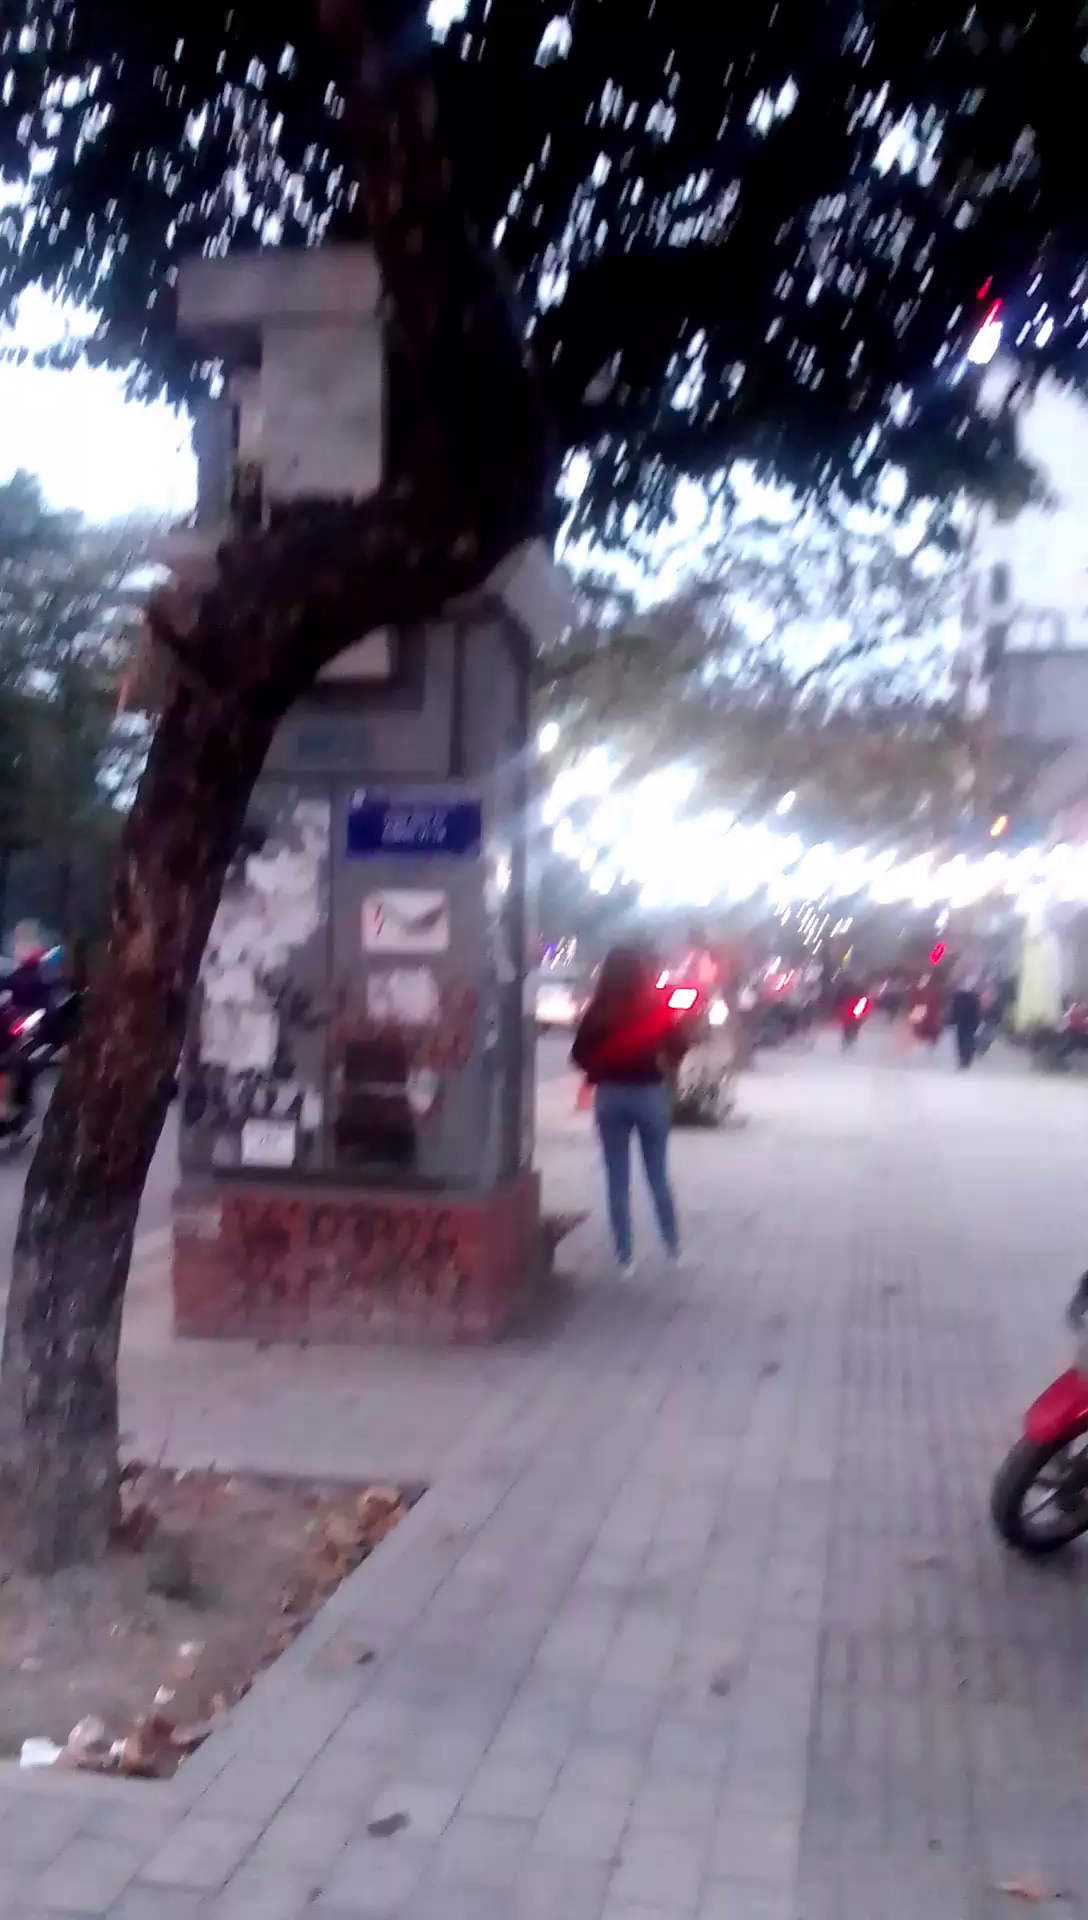

In [26]:
### Load Sample Video
vid, counts, fps, sample = load_video(video_file, -90, frame_pos)
print("There are",counts,"frames")
sample

In [27]:
cd {output_dir}

/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU


Found  1  person in the frame
Selected person 0 with area 40001.10183825344 and dfc 175.41001220276334
(96.0, 76.32103888936149, 85.66850765420327, 147.1041462937682)


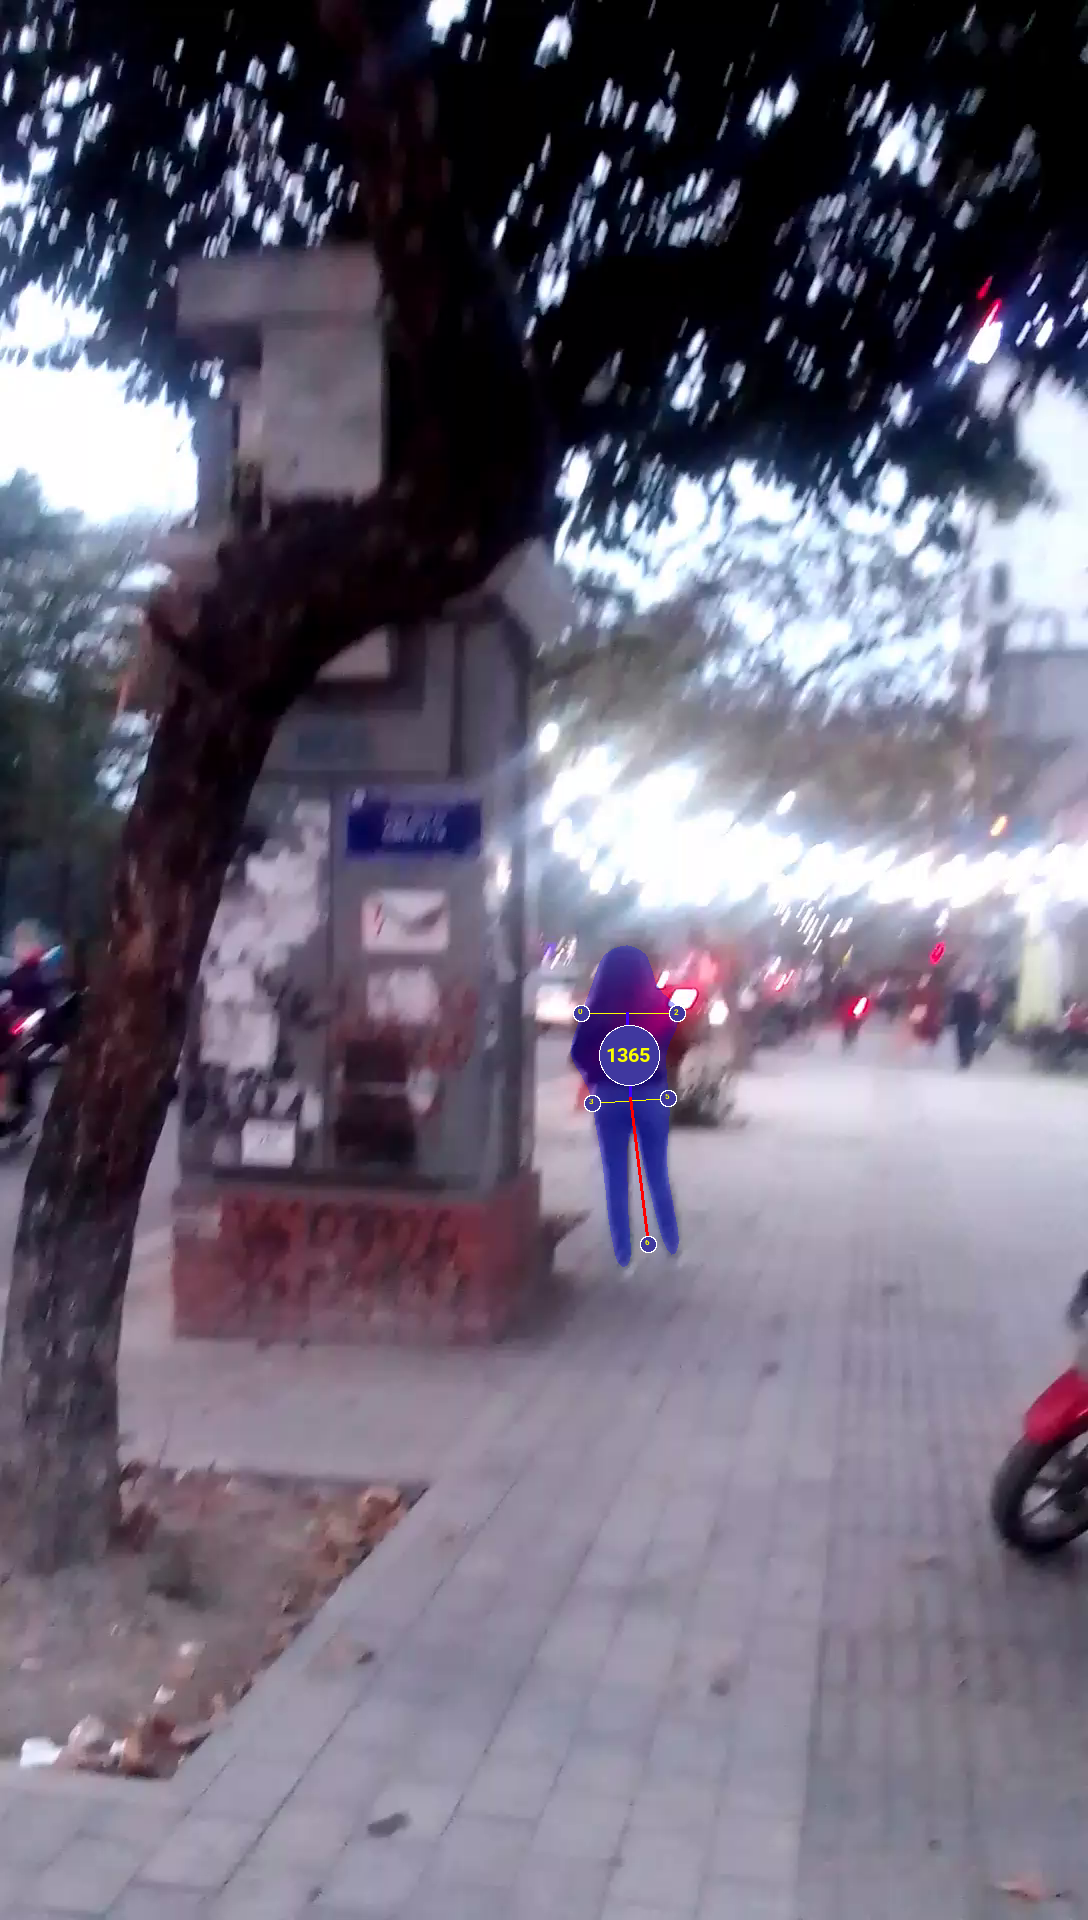

In [28]:
SHAImage, score, measures = process_frame(sample, sample_name)
print(measures)
SHAImage

## Processing Videos

In [29]:
!mkdir frames

In [30]:
cd frames

/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames


In [31]:
### Iterate over Every frames
scores = []
measures_store = []
name_len = len(str(len(vid)))
image_init = ""
missing_frames = []

for index, frame in enumerate(vid):
    image = to_pil_image(frame)
    image = image.rotate(-90, expand=True)
    if len(str(index)) < name_len :
        image_init = "0"*(name_len - len(str(index)))+str(index)
    else:
        image_init = str(index)
    image_name = image_init+"_"+video_file[-10:-4]
    try:
      SHAImage, score, measure = process_frame(image, image_name)
      scores.append(score)
      measures_store.append(measures)
    except:
      missing_frames.append(index)
   

Found  1  person in the frame
Selected person 0 with area 40001.10183825344 and dfc 175.41001220276334
Found  2  person in the frame
Selected person 0 with area 39630.193886023015 and dfc 162.7326650289589
Not selected 39630.193886023015 1 432.5858431727496
Found  1  person in the frame
Selected person 0 with area 40625.4356290251 and dfc 159.58301228917486
Found  2  person in the frame
Selected person 0 with area 43085.62078656256 and dfc 151.47477137184543
Not selected 43085.62078656256 1 327.7218154184819
Found  5  person in the frame
Selected person 0 with area 42387.39672903344 and dfc 146.94425943274163
Not selected 42387.39672903344 1 334.83698390791267
Not selected 42387.39672903344 2 456.3927129794904
Not selected 42387.39672903344 3 408.7345180998743
Not selected 42387.39672903344 4 507.9729359863981
Found  3  person in the frame
Selected person 0 with area 40321.51524860412 and dfc 155.73027548084684
Not selected 40321.51524860412 1 334.76861360423567
Not selected 40321.5152

In [32]:
scores

[1365,
 1383,
 1267,
 1161,
 1356,
 1420,
 1257,
 1346,
 1237,
 1292,
 1322,
 1293,
 1305,
 1193,
 1287,
 1436,
 1483,
 1226,
 1042,
 1172,
 1248,
 1308,
 1190,
 1254,
 1242,
 1144,
 1243,
 1547,
 1077,
 1149,
 1278,
 1359,
 1466,
 1350,
 1352,
 1402,
 1453,
 1285,
 1433,
 1188,
 1394,
 1364,
 1547,
 1441,
 1389,
 1292,
 1538,
 1440,
 1443,
 1485,
 1444,
 1411,
 1467,
 1490,
 1687,
 1372,
 1460,
 1488,
 1582,
 1428,
 1371,
 1540,
 1402,
 1440,
 1434,
 1309,
 1225,
 1528,
 1545,
 1434,
 1341,
 1166,
 1184,
 1110,
 1383,
 1373,
 1255,
 1418,
 1237,
 1239,
 1306,
 1367,
 1450,
 1471,
 1492,
 1365,
 1416,
 1443,
 1434,
 1526,
 1511,
 1550,
 1468,
 920,
 1474,
 1570,
 1555,
 1450,
 881,
 1614,
 1615]

1339.6309523809523 1364.5


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


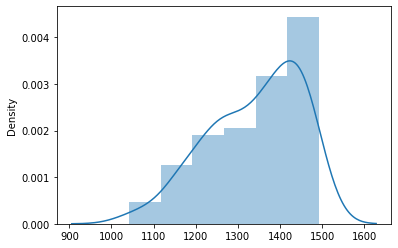

In [33]:
mean, median, minim, maxium = best_scores(scores, 1000,1500)

In [34]:
median

1364.5

In [35]:
cd ..

/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU


In [36]:
np.save("scores", scores, allow_pickle=True, fix_imports=True)

In [37]:
np.save("measures", measures, allow_pickle=True, fix_imports=True)

Generate VIDEO with BEST SCORE

In [38]:
output_video = str(median)+video_file[-10:-4]+"_BMS.mp4"
width = sample.width
height = sample.height

In [67]:
frames = os.listdir(output_dir+"/frames")
frames

['000_2240~2.png',
 '001_2240~2.png',
 '002_2240~2.png',
 '003_2240~2.png',
 '004_2240~2.png',
 '005_2240~2.png',
 '006_2240~2.png',
 '007_2240~2.png',
 '008_2240~2.png',
 '010_2240~2.png',
 '011_2240~2.png',
 '012_2240~2.png',
 '013_2240~2.png',
 '014_2240~2.png',
 '015_2240~2.png',
 '016_2240~2.png',
 '017_2240~2.png',
 '018_2240~2.png',
 '019_2240~2.png',
 '020_2240~2.png',
 '021_2240~2.png',
 '022_2240~2.png',
 '023_2240~2.png',
 '024_2240~2.png',
 '025_2240~2.png',
 '026_2240~2.png',
 '027_2240~2.png',
 '028_2240~2.png',
 '029_2240~2.png',
 '030_2240~2.png',
 '031_2240~2.png',
 '032_2240~2.png',
 '033_2240~2.png',
 '034_2240~2.png',
 '035_2240~2.png',
 '036_2240~2.png',
 '037_2240~2.png',
 '038_2240~2.png',
 '039_2240~2.png',
 '040_2240~2.png',
 '041_2240~2.png',
 '042_2240~2.png',
 '043_2240~2.png',
 '044_2240~2.png',
 '046_2240~2.png',
 '047_2240~2.png',
 '048_2240~2.png',
 '049_2240~2.png',
 '050_2240~2.png',
 '051_2240~2.png',
 '052_2240~2.png',
 '053_2240~2.png',
 '054_2240~2

In [48]:
total_frames = int(frames[-1][0:name_len])+1
total_frames

103

In [49]:
frames_path = ["" for x in range(total_frames)]
len(frames_path)

103

In [50]:
print(missing_frames)

[9, 45]


In [64]:
for missing_frame in missing_frames:
    handleMissingFrame(missing_frame)

In [71]:
updated_frames = os.listdir(output_dir+"/frames")
updated_frames

['000_2240~2.png',
 '001_2240~2.png',
 '002_2240~2.png',
 '003_2240~2.png',
 '004_2240~2.png',
 '005_2240~2.png',
 '006_2240~2.png',
 '007_2240~2.png',
 '008_2240~2.png',
 '010_2240~2.png',
 '011_2240~2.png',
 '012_2240~2.png',
 '013_2240~2.png',
 '014_2240~2.png',
 '015_2240~2.png',
 '016_2240~2.png',
 '017_2240~2.png',
 '018_2240~2.png',
 '019_2240~2.png',
 '020_2240~2.png',
 '021_2240~2.png',
 '022_2240~2.png',
 '023_2240~2.png',
 '024_2240~2.png',
 '025_2240~2.png',
 '026_2240~2.png',
 '027_2240~2.png',
 '028_2240~2.png',
 '029_2240~2.png',
 '030_2240~2.png',
 '031_2240~2.png',
 '032_2240~2.png',
 '033_2240~2.png',
 '034_2240~2.png',
 '035_2240~2.png',
 '036_2240~2.png',
 '037_2240~2.png',
 '038_2240~2.png',
 '039_2240~2.png',
 '040_2240~2.png',
 '041_2240~2.png',
 '042_2240~2.png',
 '043_2240~2.png',
 '044_2240~2.png',
 '046_2240~2.png',
 '047_2240~2.png',
 '048_2240~2.png',
 '049_2240~2.png',
 '050_2240~2.png',
 '051_2240~2.png',
 '052_2240~2.png',
 '053_2240~2.png',
 '054_2240~2

In [72]:
import os

for frame in frames:
    root_ext = os.path.splitext(frame)
    if root_ext[1] == '.png':
        frame_index = int(root_ext[0][0:-7])
        print(frame_index)
        if frame_index in missing_frames:
          frames_path[frame_index] = os.path.join(output_dir + "/frames/"+frame)
        else:
          frames_path[frame_index] = os.path.join(output_dir + "/frames/"+frame)


0
1
2
3
4
5
6
7
8
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
9
45


In [73]:
frames_path

['/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/000_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/001_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/002_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/003_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/004_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/005_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/006_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/007_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/008_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/009_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/010_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/011_2240~2.png',
 '/content/drive/MyDrive/Body_Matrix/Body_Matrix_GPU/frames/012_2240~2.png',

In [74]:
value, target_index = find_nearest(scores, median)
target_index

0

In [75]:
generate_seek_video(frames_path, target_index, output_video, sample.width, sample.height)